# poi节点附近价格可视化

## 数据准备

In [2]:
import json
import matplotlib.pyplot as plt

# macOS 推荐字体
plt.rcParams['font.family'] = 'Heiti TC'
plt.rcParams['axes.unicode_minus'] = False

In [5]:
with open("../data/poi_data_more_precise.json", "r") as f:
    data = json.load(f)
data[0]

{'id': 'node/1765216410',
 'lat': 39.8842806,
 'lon': 116.4833676,
 'tags': {'bus': 'yes',
  'highway': 'bus_stop',
  'name': '窑洼湖桥北',
  'name:zh': '窑洼湖桥北',
  'public_transport': 'stop_position'},
 'first_tag': 'public_transport',
 'second_tag': 'stop_position',
 'total_houses_count': 117,
 'average_nearby_house_price': 24839.786324786324}

✓ 地图底图加载成功


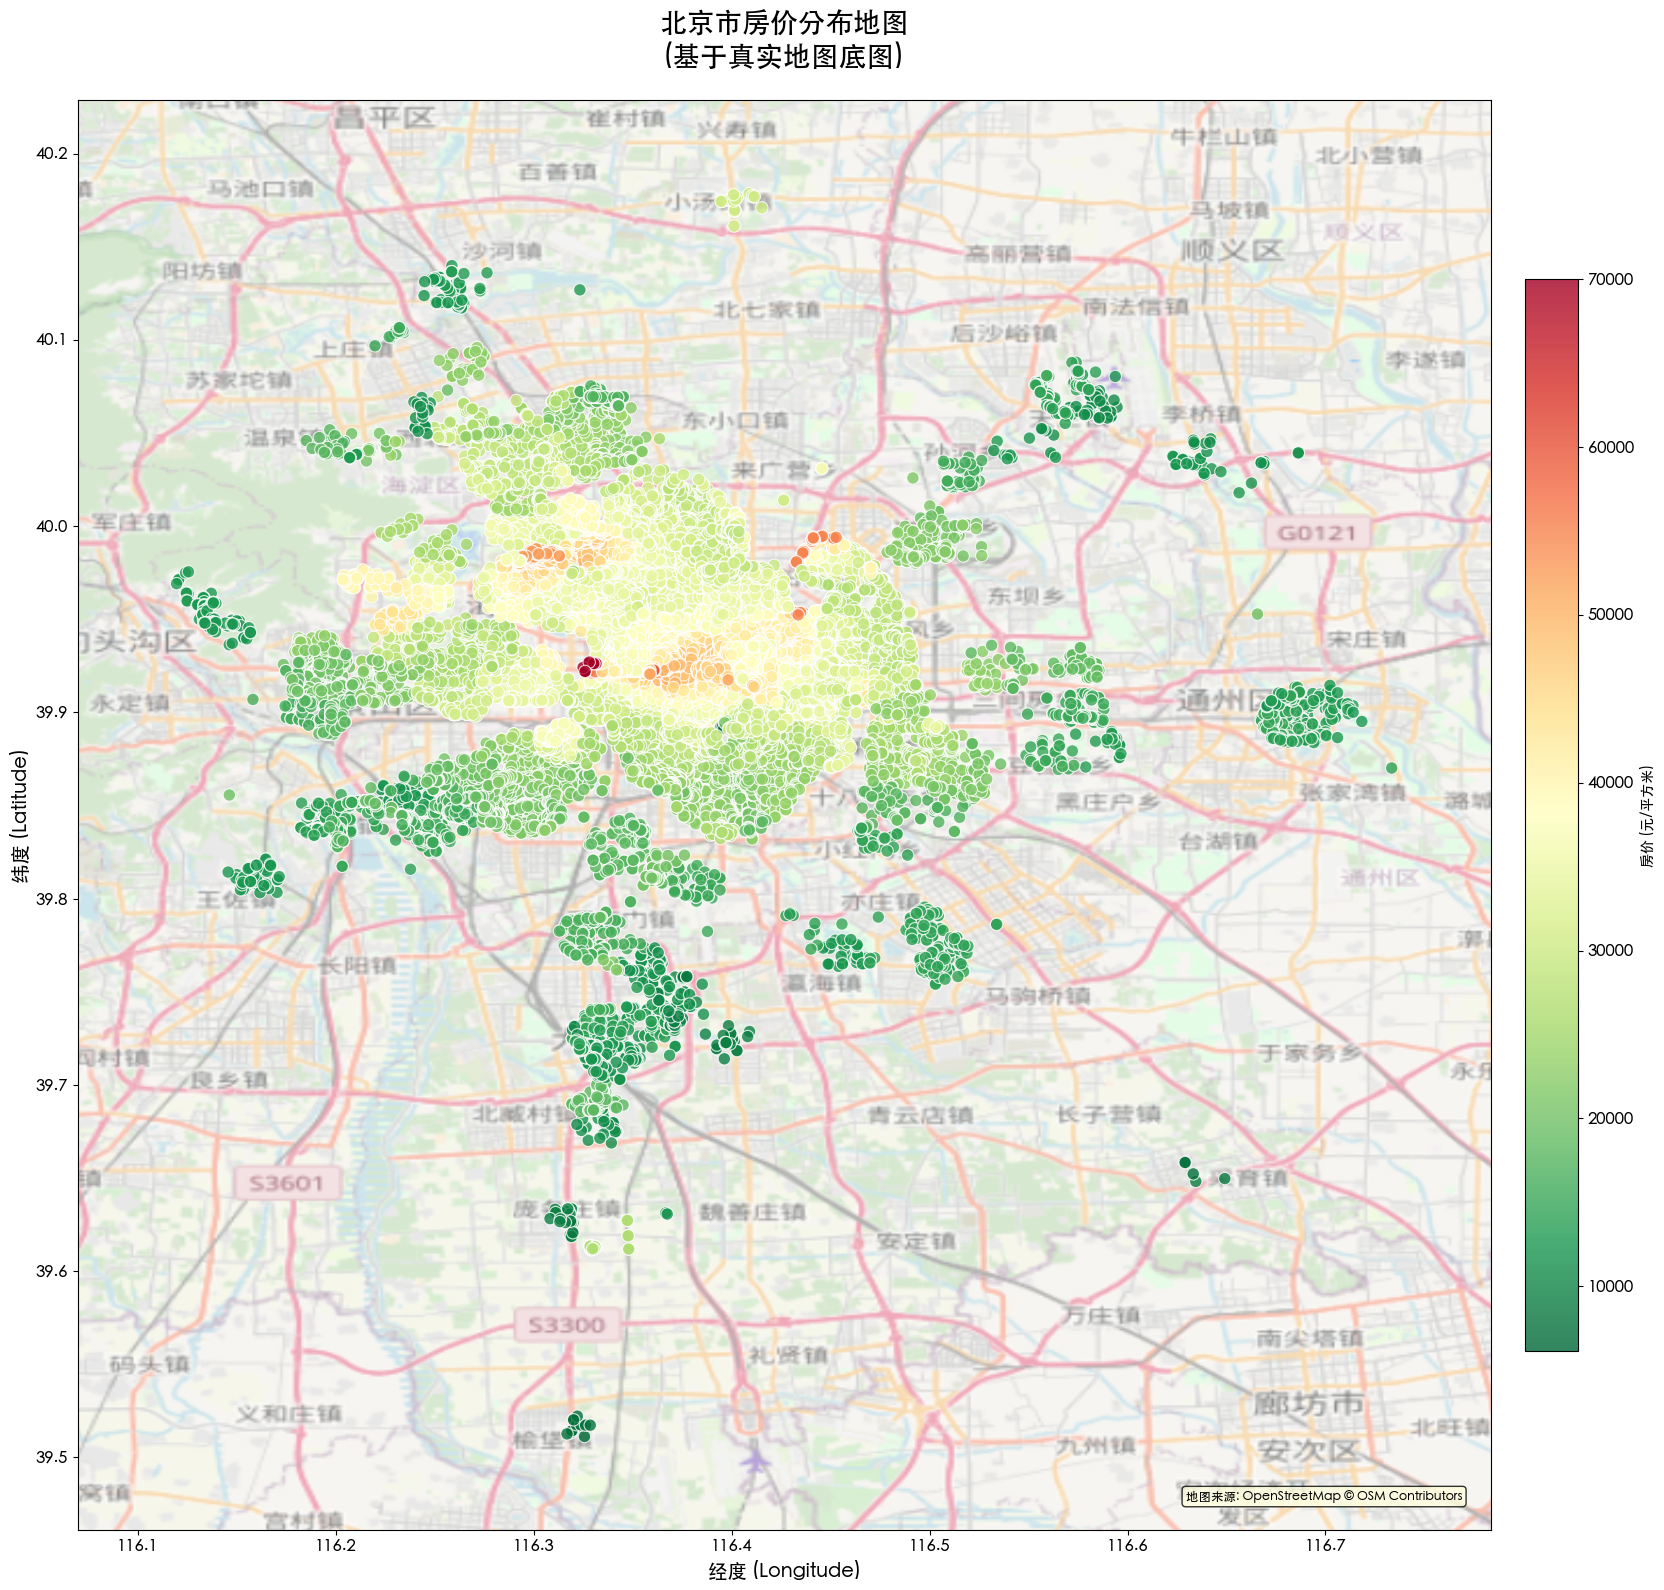


✓ 共绘制 40,887 个房源数据点
✓ 价格范围: ¥6139 - ¥70006 元/平方米
✓ 平均价格: ¥29481/㎡
✓ 地图已保存至: ../image/beijing_poi_price_map_with_basemap_v1.png


In [9]:
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np

# 提取数据
lons = []
lats = []
prices = []

for poi in data:
    try:
        lon = float(poi['lon'])
        lat = float(poi['lat'])
        price = float(poi['average_nearby_house_price'])
        
        lons.append(lon)
        lats.append(lat)
        prices.append(price)
    except (ValueError, KeyError):
        continue

# 转换为numpy数组
lons = np.array(lons)
lats = np.array(lats)
prices = np.array(prices)

# 创建图形
fig, ax = plt.subplots(figsize=(18, 16))


# 绘制散点图
scatter = ax.scatter(lons, lats, c=prices, cmap='RdYlGn_r', 
                     s=80, alpha=0.8, edgecolors='white', linewidth=0.8,
                     zorder=5)

# 添加真实地图底图（OpenStreetMap）
try:
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik, 
                    attribution=False, alpha=0.6, zorder=1)
    map_loaded = True
    print("✓ 地图底图加载成功")
except Exception as e:
    print(f"⚠ 地图底图加载失败: {e}")
    print("  使用备用方案...")
    ax.set_facecolor('#E8F4F8')
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8, color='#CCCCCC')
    map_loaded = False

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax, label='房价 (元/平方米)', pad=0.02, shrink=0.75)
cbar.ax.tick_params(labelsize=12)

# 设置标题和标签
ax.set_title('北京市房价分布地图\n(基于真实地图底图)', fontsize=20, fontweight='bold', pad=25)
ax.set_xlabel('经度 (Longitude)', fontsize=14, fontweight='bold')
ax.set_ylabel('纬度 (Latitude)', fontsize=14, fontweight='bold')

# 设置坐标轴范围
ax.set_xlim(lons.min() - 0.05, lons.max() + 0.05)
ax.set_ylim(lats.min() - 0.05, lats.max() + 0.05)

# 设置刻度格式
ax.tick_params(labelsize=12)

"""# 添加统计信息
price_stats = f'📊 统计信息\n'
price_stats += f'{"─"*20}\n'
price_stats += f'平均价格: ¥{prices.mean():.0f}/㎡\n'
price_stats += f'中位数价格: ¥{np.median(prices):.0f}/㎡\n'
price_stats += f'最高价格: ¥{prices.max():.0f}/㎡\n'
price_stats += f'最低价格: ¥{prices.min():.0f}/㎡\n'
price_stats += f'标准差: ¥{prices.std():.0f}/㎡\n'
price_stats += f'样本数量: {len(prices):,} 套'

ax.text(0.02, 0.98, price_stats, transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='white', 
                  alpha=0.95, edgecolor='darkblue', linewidth=2),
        zorder=10)"""

# 添加数据来源说明
if map_loaded:
    source_text = '地图来源: OpenStreetMap © OSM Contributors'
else:
    source_text = '备用地图模式'
    
ax.text(0.98, 0.02, source_text, transform=ax.transAxes,
        fontsize=9, horizontalalignment='right', style='italic',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
        zorder=10)


plt.tight_layout()
plt.savefig('../image/beijing_house_price_map_with_basemap.png', dpi=600, bbox_inches='tight')
plt.show()

print(f"\n✓ 共绘制 {len(prices):,} 个房源数据点")
print(f"✓ 价格范围: ¥{prices.min():.0f} - ¥{prices.max():.0f} 元/平方米")
print(f"✓ 平均价格: ¥{prices.mean():.0f}/㎡")
print(f"✓ 地图已保存至: ../image/beijing_poi_price_map_with_basemap_v1.png")

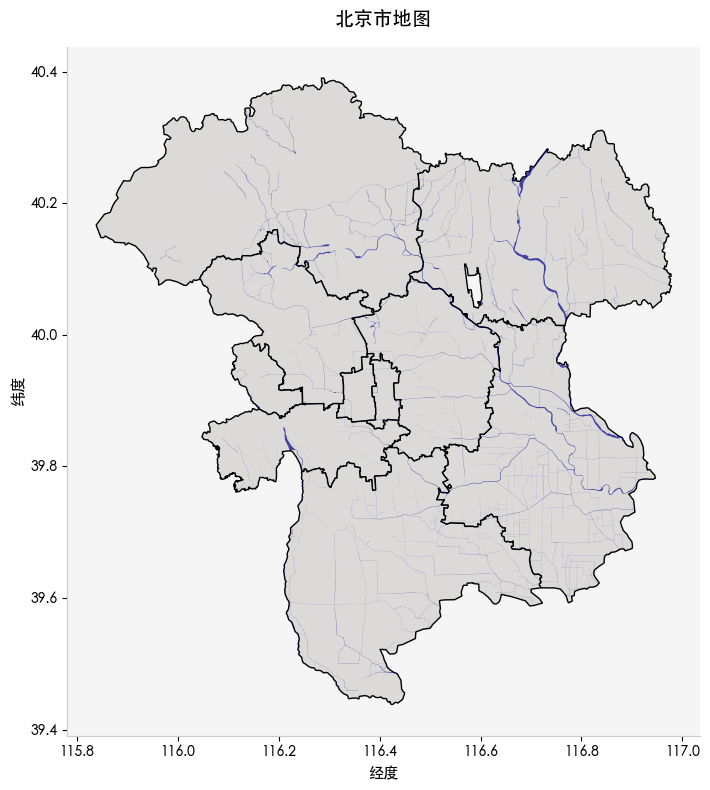

In [90]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取包含中国省市的矢量地图
beijing = gpd.read_file('../data/beijing/北京区县界.shp')
beijing_river = gpd.read_file('../data/beijing/北京河流.shp')

beijing_center_district = [
    "昌平区",
    "顺义区",
    "海淀区",
    "朝阳区",
    "石景山区",
    "西城区",
    "东城区",
    "丰台区",
    "大兴区",
    "通州区"
]
# 过滤出中心区县
beijing = beijing[beijing['NAME'].isin(beijing_center_district)]

# 用中心区县的边界裁剪河流（空间裁剪，不依赖河流的NAME字段）
beijing_boundary = beijing.union_all()  # 合并所有中心区县为一个多边形
beijing_river = gpd.clip(beijing_river, beijing_boundary)

# 绘制地图 - 高级配色方案
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
ax.set_facecolor('#F5F5F5')  # 浅灰色背景

beijing.plot(ax=ax, facecolor='#dbdad9', edgecolor='black', linewidth=1)

beijing_river.plot(ax=ax, color='darkblue', linewidth=1.2, alpha=0.7)

plt.title('北京市地图', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('经度', fontsize=11)
plt.ylabel('纬度', fontsize=11)

# 去除顶部和右侧边框，更简洁
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

plt.tight_layout()
plt.savefig("../image/beijing_district.png", dpi=600)
plt.show()


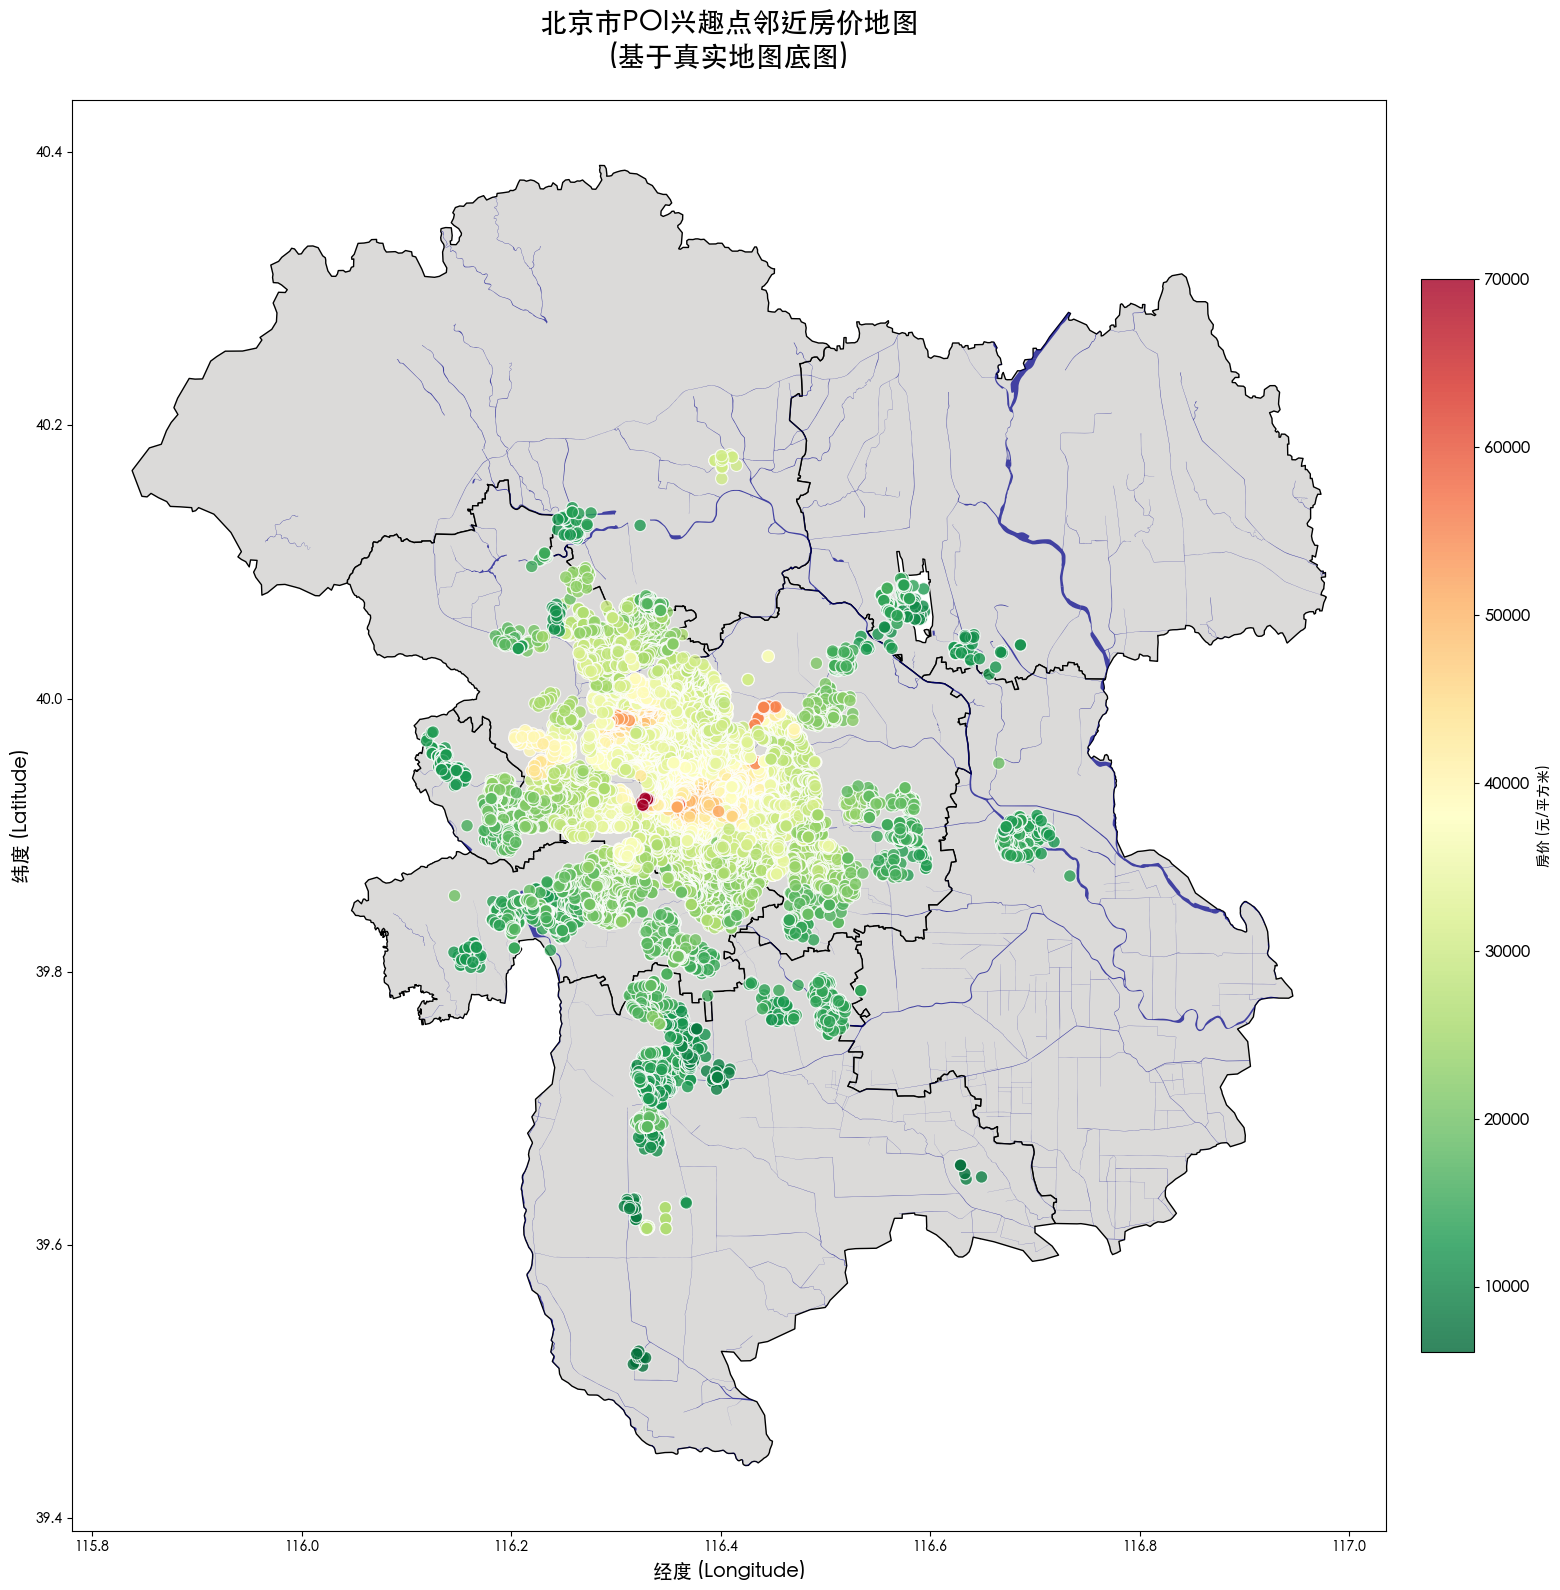

In [8]:
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np

# 提取数据
lons = []
lats = []
prices = []

for poi in data:
    try:
        lon = float(poi['lon'])
        lat = float(poi['lat'])
        price = float(poi['average_nearby_house_price'])
        
        lons.append(lon)
        lats.append(lat)
        prices.append(price)
    except (ValueError, KeyError):
        continue

# 转换为numpy数组
lons = np.array(lons)
lats = np.array(lats)
prices = np.array(prices)

# 创建图形
fig, ax = plt.subplots(figsize=(18, 16))
beijing.plot(ax=ax, facecolor='#dbdad9', edgecolor='black', linewidth=1)
# 河流 - 蓝色，半透明
beijing_river.plot(ax=ax, color='darkblue', linewidth=1.2, alpha=0.7)
# 绘制散点图
scatter = ax.scatter(lons, lats, c=prices, cmap='RdYlGn_r', 
                     s=80, alpha=0.8, edgecolors='white', linewidth=0.8,
                     zorder=5)


# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax, label='房价 (元/平方米)', pad=0.02, shrink=0.75)
cbar.ax.tick_params(labelsize=12)

# 设置标题和标签
ax.set_title('北京市POI兴趣点邻近房价地图\n(基于真实地图底图)', fontsize=20, fontweight='bold', pad=25)
ax.set_xlabel('经度 (Longitude)', fontsize=14, fontweight='bold')
ax.set_ylabel('纬度 (Latitude)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../image/beijing_poi_price_map.png', dpi=600, bbox_inches='tight')
plt.show()


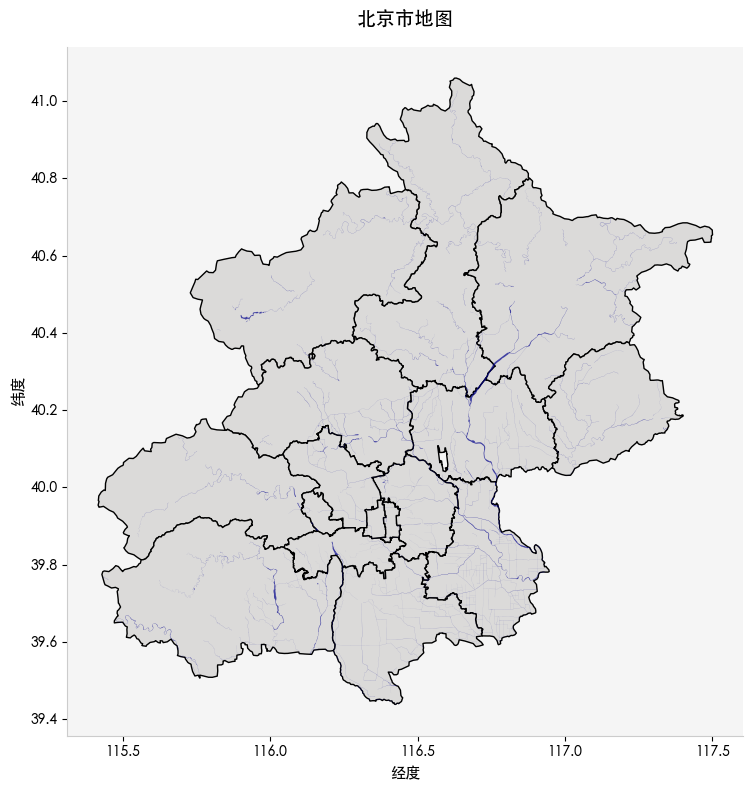

In [93]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取包含中国省市的矢量地图
beijing = gpd.read_file('../data/beijing/北京区县界.shp')
beijing_river = gpd.read_file('../data/beijing/北京河流.shp')


# 绘制地图 - 高级配色方案
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
ax.set_facecolor('#F5F5F5')  # 浅灰色背景

beijing.plot(ax=ax, facecolor='#dbdad9', edgecolor='black', linewidth=1)

beijing_river.plot(ax=ax, color='darkblue', linewidth=1.2, alpha=0.7)

plt.title('北京市地图', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('经度', fontsize=11)
plt.ylabel('纬度', fontsize=11)

# 去除顶部和右侧边框，更简洁
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

plt.tight_layout()
plt.savefig("../image/beijing_district.png", dpi=600)
plt.show()

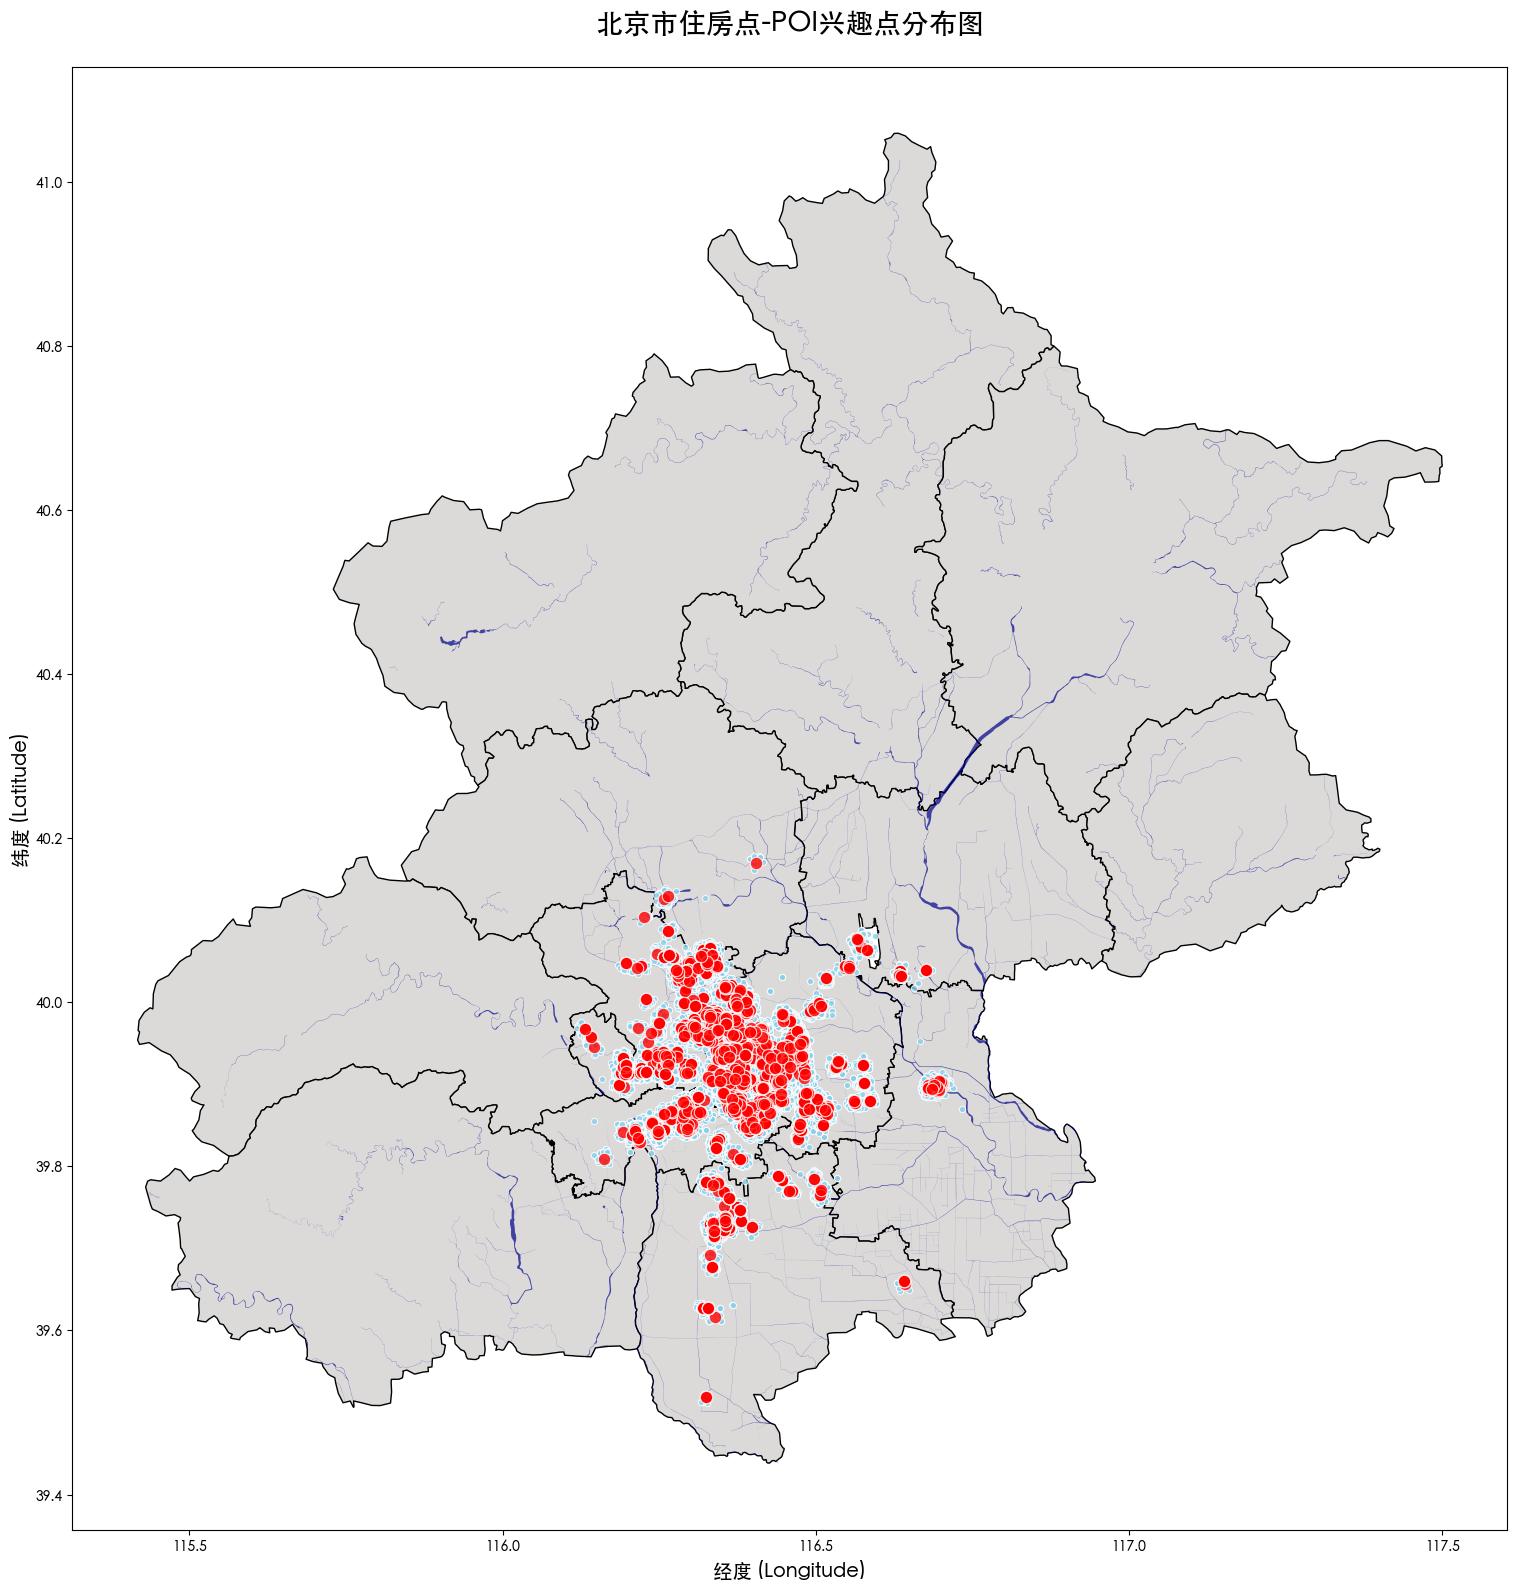

In [99]:
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
with open("../data/house_data.json", 'r') as f:
    houses = json.load(f)
with open("../data/poi_data.json", 'r') as f:
    pois= json.load(f)
    
# 提取房屋数据
lons = []
lats = []
prices = []

for house in houses:
    try:
        lon = float(house['lon'])
        lat = float(house['lat'])
        price = float(house['price_per_meter'])
        
        lons.append(lon)
        lats.append(lat)
        prices.append(price)
    except (ValueError, KeyError):
        continue

# 转换为numpy数组
lons = np.array(lons)
lats = np.array(lats)
prices = np.array(prices)

# 创建图形
fig, ax = plt.subplots(figsize=(18, 16))

# 绘制散点图
scatter = ax.scatter(lons, lats, c="red",
                     s=80, alpha=0.8, edgecolors='white', linewidth=0.8,
                     zorder=5)

# 提取poi数据
lons = []
lats = []

for poi in pois:
    try:
        lon = float(poi['lon'])
        lat = float(poi['lat'])
        
        lons.append(lon)
        lats.append(lat)
    except (ValueError, KeyError):
        continue

# 转换为numpy数组
lons = np.array(lons)
lats = np.array(lats)

# 绘制散点图
scatter = ax.scatter(lons, lats, c='#87CEEB', 
                     s=20, alpha=0.8, edgecolors='white', linewidth=0.8,
                     zorder=4)


beijing.plot(ax=ax, facecolor='#dbdad9', edgecolor='black', linewidth=1)

beijing_river.plot(ax=ax, color='darkblue', linewidth=1.2, alpha=0.7)

# 设置标题和标签
ax.set_title('北京市住房点-POI兴趣点分布图', fontsize=20, fontweight='bold', pad=25)
ax.set_xlabel('经度 (Longitude)', fontsize=14, fontweight='bold')
ax.set_ylabel('纬度 (Latitude)', fontsize=14, fontweight='bold')



plt.tight_layout()
plt.savefig('../image/beijing_house_poi_map.png', dpi=600, bbox_inches='tight')
plt.show()

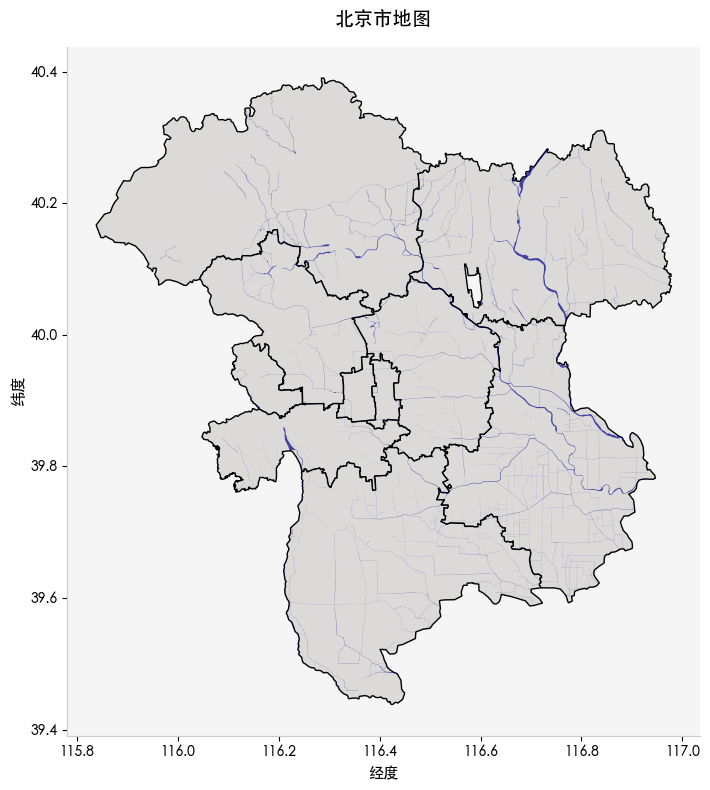

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取包含中国省市的矢量地图
beijing = gpd.read_file('../data/beijing/北京区县界.shp')
beijing_river = gpd.read_file('../data/beijing/北京河流.shp')

beijing_center_district = [
    "昌平区",
    "顺义区",
    "海淀区",
    "朝阳区",
    "石景山区",
    "西城区",
    "东城区",
    "丰台区",
    "大兴区",
    "通州区"
]
# 过滤出中心区县
beijing = beijing[beijing['NAME'].isin(beijing_center_district)]

# 用中心区县的边界裁剪河流（空间裁剪，不依赖河流的NAME字段）
beijing_boundary = beijing.union_all()  # 合并所有中心区县为一个多边形
beijing_river = gpd.clip(beijing_river, beijing_boundary)

# 绘制地图 - 高级配色方案
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
ax.set_facecolor('#F5F5F5')  # 浅灰色背景

beijing.plot(ax=ax, facecolor='#dbdad9', edgecolor='black', linewidth=1)

beijing_river.plot(ax=ax, color='darkblue', linewidth=1.2, alpha=0.7)

plt.title('北京市地图', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('经度', fontsize=11)
plt.ylabel('纬度', fontsize=11)

# 去除顶部和右侧边框，更简洁
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

plt.tight_layout()
plt.savefig("../image/beijing_district.png", dpi=600)
plt.show()


In [4]:
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np

# 提取数据
lons = []
lats = []
prices = []

for poi in data:
    try:
        lon = float(poi['lon'])
        lat = float(poi['lat'])
        price = float(poi['average_nearby_house_price'])
        
        lons.append(lon)
        lats.append(lat)
        prices.append(price)
    except (ValueError, KeyError):
        continue

# 转换为numpy数组
lons = np.array(lons)
lats = np.array(lats)
prices = np.array(prices)

# 创建图形
fig, ax = plt.subplots(figsize=(18, 16))
beijing.plot(ax=ax, facecolor='#dbdad9', edgecolor='black', linewidth=1)
# 河流 - 蓝色，半透明
beijing_river.plot(ax=ax, color='darkblue', linewidth=1.2, alpha=0.7)
# 绘制散点图
scatter = ax.scatter(lons, lats, c=prices, cmap='RdYlGn_r', 
                     s=80, alpha=0.8, edgecolors='white', linewidth=0.8,
                     zorder=5)


# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax, label='房价 (元/平方米)', pad=0.02, shrink=0.75)
cbar.ax.tick_params(labelsize=12)

# 设置标题和标签
ax.set_title('北京市房价分布地图\n(基于真实地图底图)', fontsize=20, fontweight='bold', pad=25)
ax.set_xlabel('经度 (Longitude)', fontsize=14, fontweight='bold')
ax.set_ylabel('纬度 (Latitude)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../image/beijing_house_price_map.png', dpi=600, bbox_inches='tight')
plt.show()


NameError: name 'data' is not defined